<a href="https://colab.research.google.com/github/Jayavathsan/DeepLearning/blob/main/PyTorch/TransferLearning/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning with ResNet18


In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
%matplotlib notebook

In [3]:
%matplotlib inline

In [4]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import a dataset

In [6]:
#     resnet is trained for images in a specific range (NOT [-1,1]).
#     That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

100%|██████████| 2640397119/2640397119 [02:37<00:00, 16768591.91it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [7]:
# shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [8]:
# load the next iteration to implement the changes
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


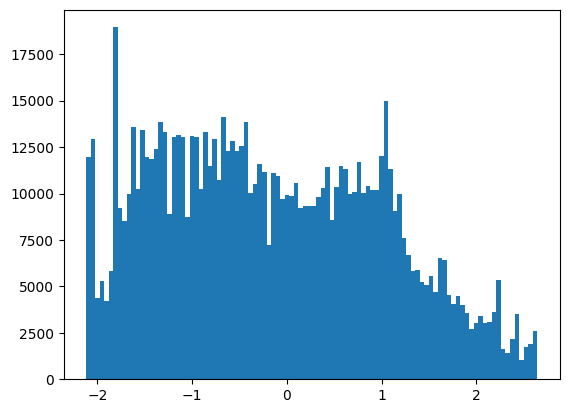

In [9]:
# histogram of the data
plt.hist(X.data.numpy().flatten(),100);

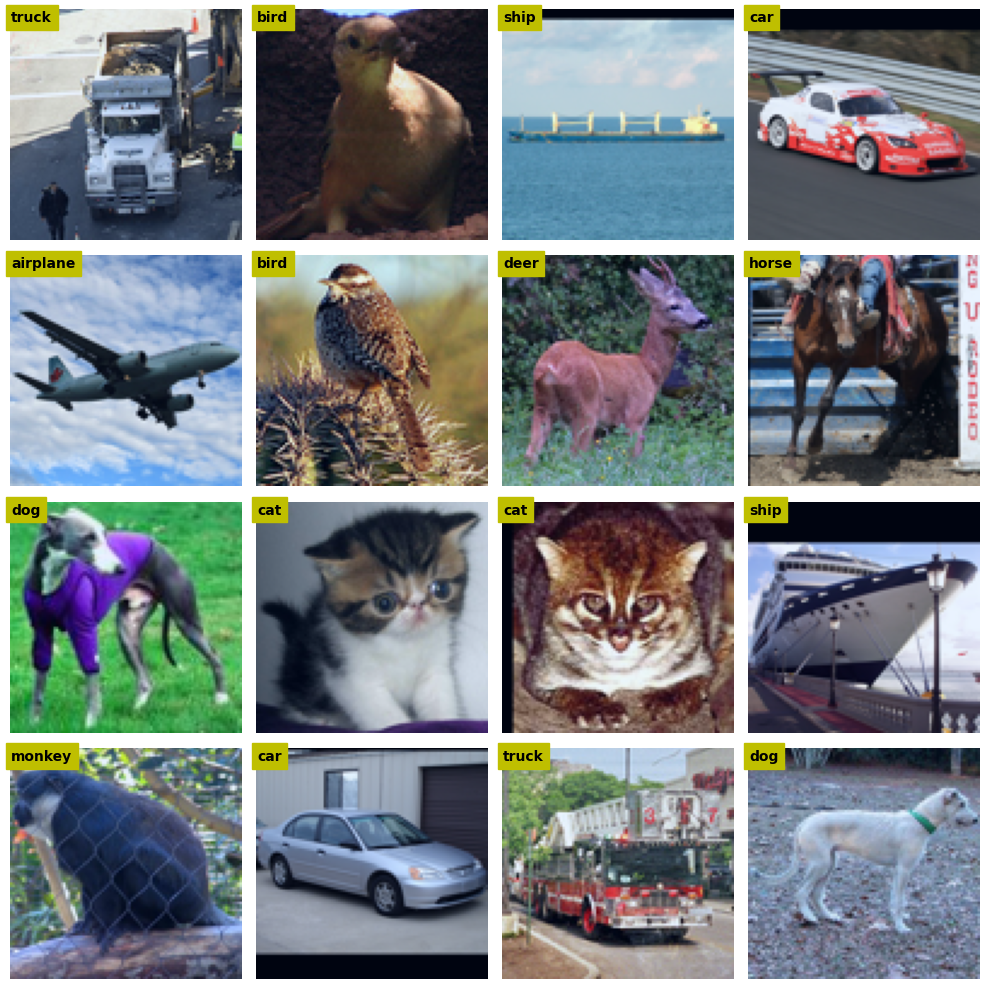

In [10]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # and its label
  label = trainset.classes[y[i]]

  # view
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Import and inspect the resnet model

In [11]:
# resnet = torchvision.models.resnet18(pretrained=True)
weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet = torchvision.models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 285MB/s]


In [12]:
# resnet architecture
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from torchsummary import summary
summary(resnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [14]:
# Freeze all layers
for p in resnet.parameters():
    p.requires_grad = False #p.requires_grad_(False)

In [15]:
# final layer
resnet.fc = nn.Linear(512,10)

In [16]:
# push the model to the GPU
resnet.to(device);

# Train the model

In [17]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(),lr=0.0005) #,momentum=.9)

In [18]:
numepochs = 20

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/20. Test accuracy = 71.59%
Finished epoch 2/20. Test accuracy = 75.98%
Finished epoch 3/20. Test accuracy = 77.45%
Finished epoch 4/20. Test accuracy = 77.80%
Finished epoch 5/20. Test accuracy = 78.67%
Finished epoch 6/20. Test accuracy = 78.36%
Finished epoch 7/20. Test accuracy = 79.00%
Finished epoch 8/20. Test accuracy = 78.81%
Finished epoch 9/20. Test accuracy = 79.47%
Finished epoch 10/20. Test accuracy = 79.38%
Finished epoch 11/20. Test accuracy = 78.81%
Finished epoch 12/20. Test accuracy = 79.36%
Finished epoch 13/20. Test accuracy = 79.44%
Finished epoch 14/20. Test accuracy = 79.36%
Finished epoch 15/20. Test accuracy = 79.39%
Finished epoch 16/20. Test accuracy = 79.76%
Finished epoch 17/20. Test accuracy = 79.36%
Finished epoch 18/20. Test accuracy = 78.92%
Finished epoch 19/20. Test accuracy = 79.54%
Finished epoch 20/20. Test accuracy = 79.66%


# Visualize the performance

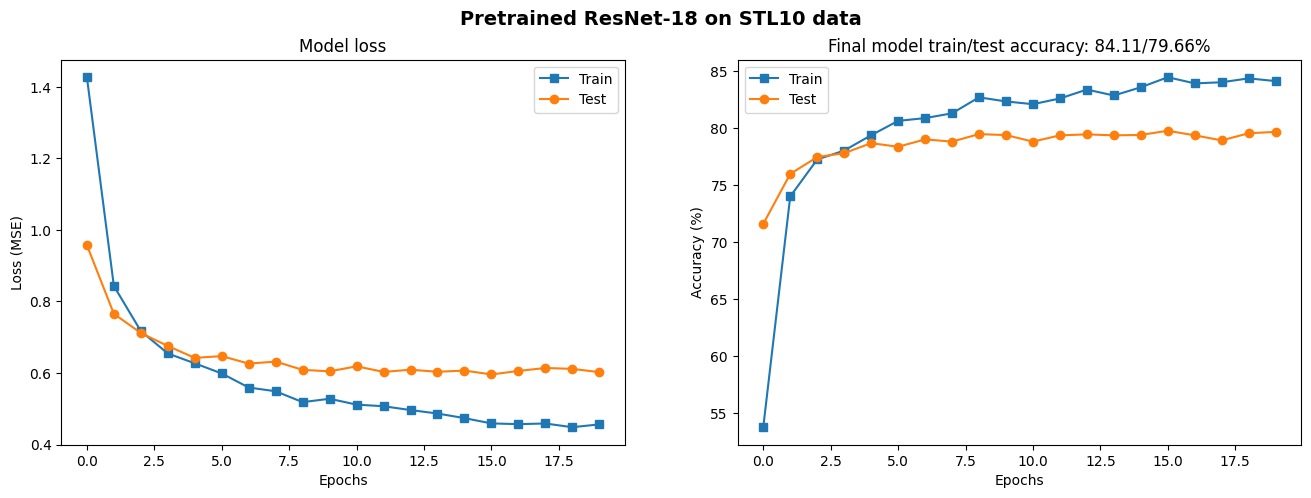

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

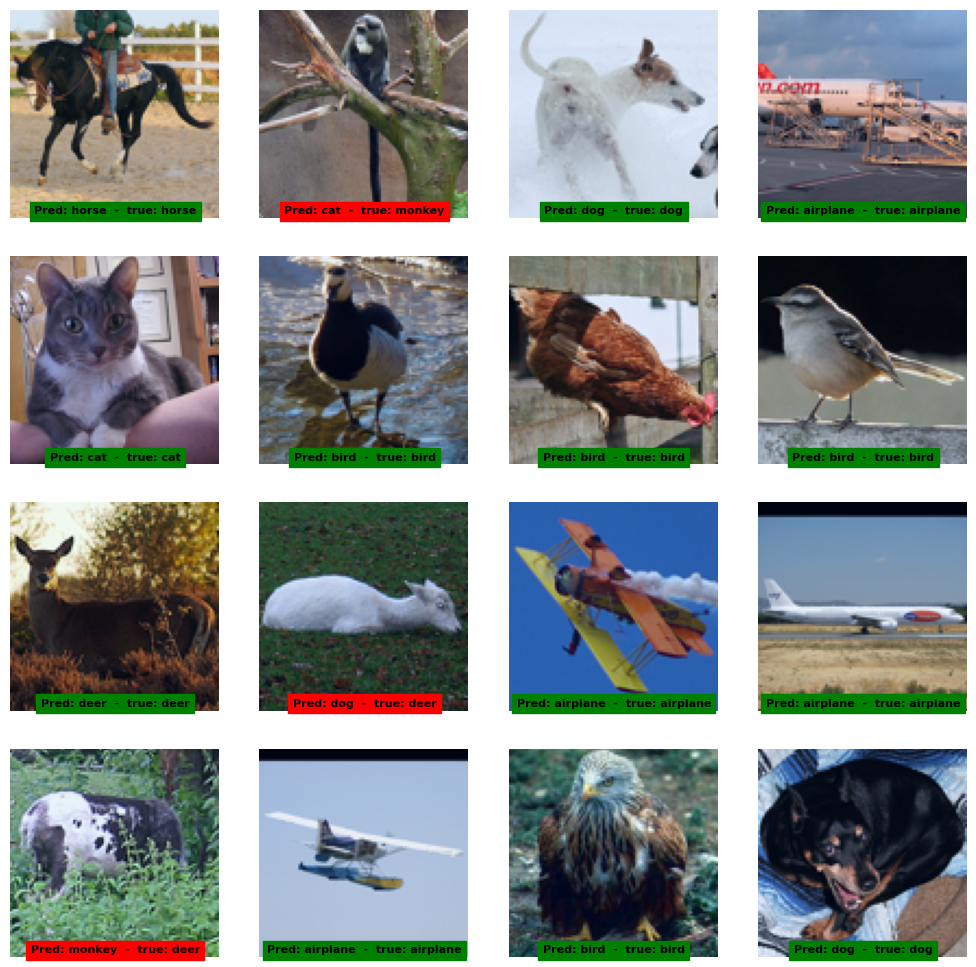

In [20]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image, transpose it back to 96x96x3
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # show the image
  ax.imshow(pic)


  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()